/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


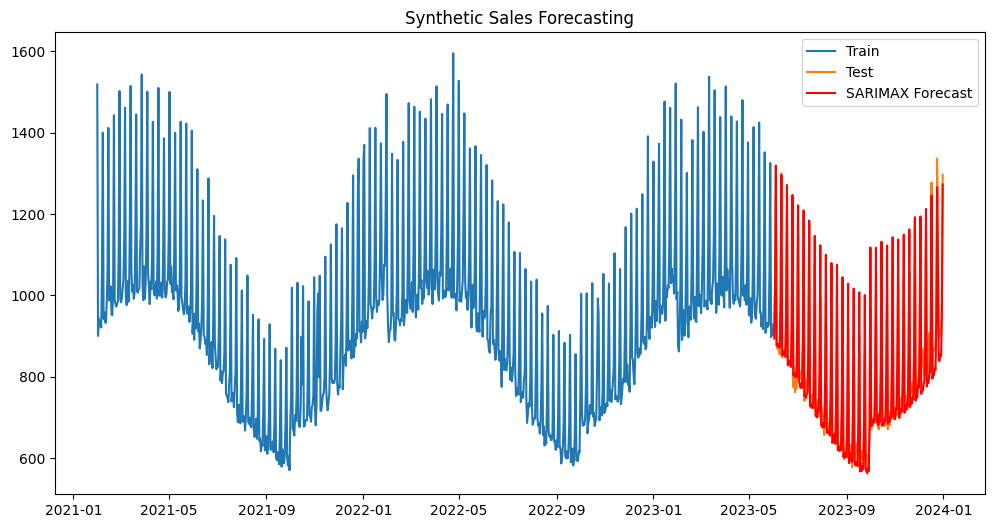

                                     SARIMAX Results                                     
Dep. Variable:                       total_sales   No. Observations:                  852
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4035.931
Date:                           Fri, 12 Dec 2025   AIC                           8097.861
Time:                                   16:16:48   BIC                           8159.318
Sample:                               01-31-2021   HQIC                          8121.422
                                    - 06-01-2023                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
price             -0.7533      4.569     -0.165      0.869      -9.709       8.203
cpi               -1.1596      

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('/content/FINAL_DATASET_3ys.csv')
df['date'] = pd.to_datetime(df['date'])

# 2. Define Features to Drop (Leakage & Identifiers)
cols_to_drop = [
    'product_id', 'product_name', 'category', 'branch_id', 'branch_name', 'order_id', # Identifiers
    'online_sales', 'offline_sales', # Data Leakage (Components of target)
    'returns_count', # Future unknown
    'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_mean_30' # SARIMAX handles lags internally
]
df = df.drop(columns=cols_to_drop)

# 3. Aggregation Strategy (Handling duplicates)
# We aggregate to get ONE row per day
agg_rules = {
    'total_sales': 'sum',    # Target: Sum of all sales
    'price': 'mean',         # Exog: Average price that day
    'cpi': 'mean',           # Exog: Economic indicator
    'seasonal_index': 'mean',# Exog: Seasonality
    'promotion_flag': 'max', # Exog: Was there a promo anywhere?
    'festival_flag': 'max',  # Exog: Was it a festival?
    'holiday_flag': 'max',   # Exog: Was it a holiday?
    'day_of_week': 'first',  # Static time feature
    'month': 'first'         # Static time feature
}

df_daily = df.groupby('date').agg(agg_rules)

# 4. Set Frequency (Crucial for SARIMAX)
df_daily = df_daily.asfreq('D')

# 5. Define Endogenous (Y) and Exogenous (X)
endog = df_daily['total_sales']
exog = df_daily.drop(columns=['total_sales'])

# 6. Train/Test Split (Time-based)
train_size = int(len(endog) * 0.8)
train_y, test_y = endog.iloc[:train_size], endog.iloc[train_size:]
train_x, test_x = exog.iloc[:train_size], exog.iloc[train_size:]

# 7. Fit SARIMAX
# Note: You can use auto_arima to find order=(p,d,q) and seasonal_order=(P,D,Q,s)
# Here we use a standard weekly seasonality assumption (s=7)
model = SARIMAX(
    endog=train_y,
    exog=train_x,
    order=(1, 1, 1),              # (p,d,q) - Tune this
    seasonal_order=(1, 1, 1, 7),  # (P,D,Q,s) - Weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)

# 8. Forecast
# To forecast, we need Future Exogenous variables.
# For the test set validation, we use test_x.
predictions = results.get_prediction(start=len(train_y), end=len(train_y)+len(test_y)-1, exog=test_x)
pred_mean = predictions.predicted_mean

# 9. Visualize
plt.figure(figsize=(12,6))
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')
plt.plot(pred_mean.index, pred_mean, label='SARIMAX Forecast', color='red')
plt.legend()
plt.title("Synthetic Sales Forecasting")
plt.show()

print(results.summary())

In [3]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 12.5 MB/s eta 0:00:00


Starting Auto-ARIMA search... this may take a few minutes.
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=8172.387, Time=21.98 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=8524.001, Time=0.42 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=8299.983, Time=10.11 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=8167.487, Time=7.48 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=8522.031, Time=0.89 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=8522.436, Time=3.43 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=8167.616, Time=7.93 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=8167.285, Time=16.64 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=8168.047, Time=19.30 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=8172.167, Time=13.93 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=8162.706, Time=17.82 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=8163.717, Time=14.49 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=8162.134, Time=37.15 sec
 ARIMA(1,0,1)(1,1,1)[7] intercep

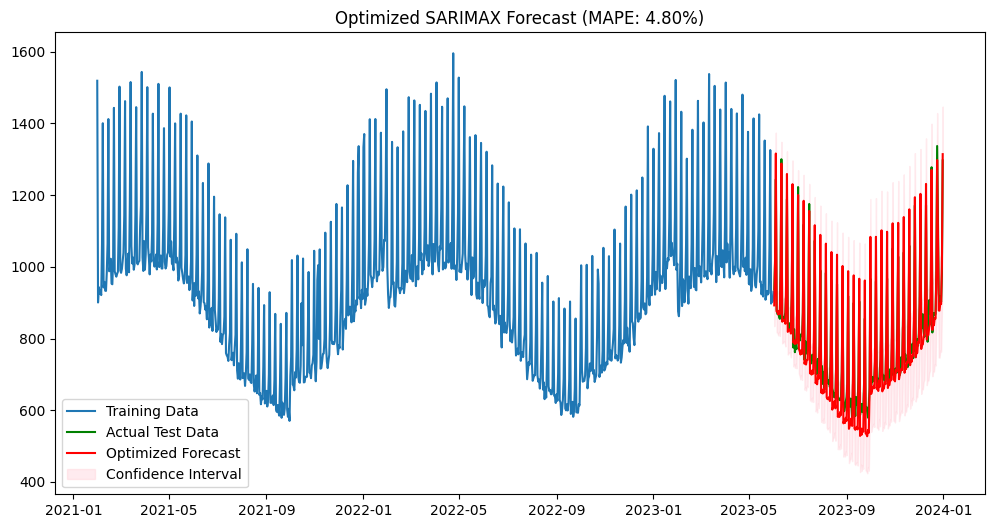

In [4]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# 1. Ensure data is prepared (from previous step)
# df_daily is your aggregated, daily frequency DataFrame
# train_y, test_y, train_x, test_x are already defined

print("Starting Auto-ARIMA search... this may take a few minutes.")

# 2. Auto-ARIMA Search
# We instruct it to find the best (p,d,q) and (P,D,Q) for m=7 (Weekly seasonality)
# We also include the exogenous variables (train_x)
optimized_model = pm.auto_arima(
    y=train_y,
    X=train_x,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    m=7,              # Weekly seasonality
    start_P=0, seasonal=True,
    d=None, D=1,      # Let it determine 'd', force 'D=1' for seasonal diff
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(f"Best Model Parameters: {optimized_model.order} x {optimized_model.seasonal_order}")

# 3. Forecast using the Best Model
# We must provide the Future Exogenous variables (test_x) for the forecast period
forecast, conf_int = optimized_model.predict(
    n_periods=len(test_y),
    X=test_x,
    return_conf_int=True
)

# 4. Evaluation Metrics
rmse = np.sqrt(mean_squared_error(test_y, forecast))
mape = mean_absolute_percentage_error(test_y, forecast)

print(f"\nModel Performance on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")

# 5. Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_y.index, train_y, label='Training Data')
plt.plot(test_y.index, test_y, label='Actual Test Data', color='green')
plt.plot(test_y.index, forecast, label='Optimized Forecast', color='red')
plt.fill_between(test_y.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title(f"Optimized SARIMAX Forecast (MAPE: {mape:.2%})")
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import numpy as np

# Generate predictions on the test set
# test_x are the exogenous variables corresponding to the test_y dates
predictions, conf_int = loaded_model.predict(n_periods=len(test_y), X=test_x, return_conf_int=True)

# 1. RMSE (Root Mean Squared Error)
# Penalizes large errors heavily. Good for "general" accuracy.
rmse = np.sqrt(mean_squared_error(test_y, predictions))

# 2. MAPE (Mean Absolute Percentage Error)
# Easier to explain to stakeholders (e.g., "we are off by 5%").
# Note: Can be unstable if actual sales are 0.
mape = mean_absolute_percentage_error(test_y, predictions)

# 3. MAE (Mean Absolute Error)
# The average absolute difference. Robust to outliers.
mae = mean_absolute_error(test_y, predictions)

print(f"Model Evaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2%}")
print(f"MAE:  {mae:.4f}")

Model Evaluation Metrics:
RMSE: 46.1033
MAPE: 4.80%
MAE:  37.3028


In [5]:
import joblib

# Assuming 'optimized_model' is your trained auto_arima model
joblib.dump(optimized_model, 'sarimax_model.joblib')
print("Model saved successfully as 'sarimax_model.joblib'")

Model saved successfully as 'sarimax_model.joblib'


In [6]:
# Later, or in a different script/app
loaded_model = joblib.load('sarimax_model.joblib')
print("Model loaded successfully.")

Model loaded successfully.
